In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
df = pd.read_csv("이상치제거.csv", encoding= 'cp949')
df.columns

Index(['Unnamed: 0', '시점', '시군산지', '일자', '품종', '도매가격.원.kg.', '거래량.톤.',
       '거래금액.백만원.', '마늘.면적..ha.', 'X10a당.생산량..kg.', '생산량..톤.', 'X10a당.생산량.톤',
       '평균', '평균기온..C.', '일강수량.mm.', '평균.풍속.m.s.', '합계.일조시간.hr.',
       '평균.지면온도..C.', '평균.5cm.지중온도..C.'],
      dtype='object')

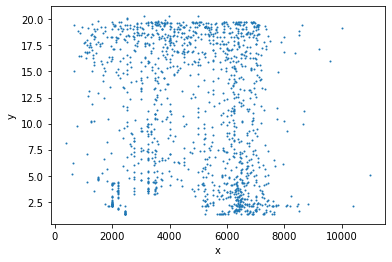

In [13]:
X_train = df['도매가격.원.kg.']
y_train = df['평균기온..C.']


plt.plot(X_train, y_train, 'o', markersize=1)
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('images/13_5.png', dpi=300)
plt.show()

In [16]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

In [17]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b


model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [18]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)


<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

In [19]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [21]:
tf.random.set_seed(1)

num_epochs = 20
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('에포크 {:3d} 스텝 {:4d} 손실 {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

에포크   0 스텝    0 손실 1.1004
에포크   0 스텝  100 손실 5.4113
에포크   0 스텝  200 손실 24.1176
에포크   0 스텝  300 손실 44.3638
에포크   0 스텝  400 손실 54.0619
에포크   0 스텝  500 손실 46.3105
에포크   0 스텝  600 손실 17.0073
에포크   0 스텝  700 손실 11.6337
에포크   0 스텝  800 손실 63.7240
에포크   0 스텝  900 손실 27.5410
에포크   0 스텝 1000 손실 3.3453
에포크   0 스텝 1100 손실 75.6232
에포크   0 스텝 1200 손실 24.1103
에포크   0 스텝 1300 손실 26.7919
에포크   1 스텝 1400 손실 14.1072
에포크   1 스텝 1500 손실 40.6534
에포크   1 스텝 1600 손실 65.2048
에포크   1 스텝 1700 손실 72.1050
에포크   1 스텝 1800 손실 74.5301
에포크   1 스텝 1900 손실 66.4195
에포크   1 스텝 2000 손실 47.0687
에포크   1 스텝 2100 손실 81.8996
에포크   1 스텝 2200 손실 58.0823
에포크   1 스텝 2300 손실 58.2133
에포크   1 스텝 2400 손실 30.1626
에포크   1 스텝 2500 손실 100.9627
에포크   1 스텝 2600 손실 52.4570
에포크   1 스텝 2700 손실 58.6414
에포크   2 스텝 2800 손실 69.5783
에포크   2 스텝 2900 손실 9.9392
에포크   2 스텝 3000 손실 48.5495
에포크   2 스텝 3100 손실 87.1847
에포크   2 스텝 3200 손실 20.0651
에포크   2 스텝 3300 손실 8.7690
에포크   2 스텝 3400 손실 32.0683
에포크   2 스텝 3500 손실 15.0502
에포크   2 스텝 3600 손실 64.1695
에포크  

최종 파라미터: -1.0784247 11.219205


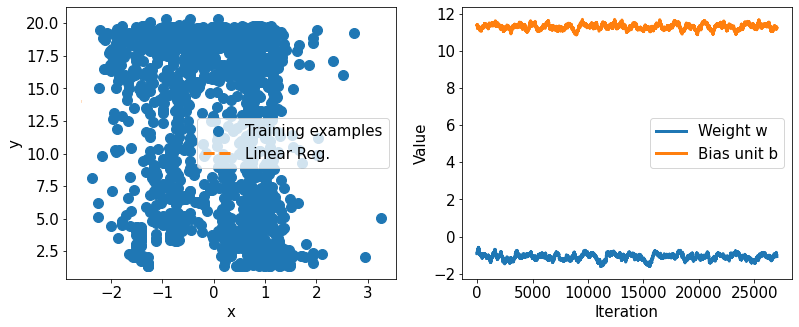

In [22]:
print('최종 파라미터:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# plt.savefig('images/13_6.png', dpi=300)
plt.show()

In [23]:
tf.random.set_seed(1)
model = MyModel()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

In [24]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)

Epoch 1/20
1352/1352 [==============================] - 2s 1ms/step - loss: 44.7279 - mae: 6.0138 - mse: 44.7279
Epoch 2/20
1352/1352 [==============================] - 1s 904us/step - loss: 42.7008 - mae: 5.9250 - mse: 42.7008
Epoch 3/20
1352/1352 [==============================] - 2s 1ms/step - loss: 42.6045 - mae: 5.9391 - mse: 42.6045
Epoch 4/20
1352/1352 [==============================] - 2s 1ms/step - loss: 42.8334 - mae: 5.9573 - mse: 42.8334
Epoch 5/20
1352/1352 [==============================] - 2s 1ms/step - loss: 42.9195 - mae: 5.9489 - mse: 42.9195
Epoch 6/20
1352/1352 [==============================] - 2s 1ms/step - loss: 42.4304 - mae: 5.8983 - mse: 42.4304
Epoch 7/20
1352/1352 [==============================] - 1s 1ms/step - loss: 42.7263 - mae: 5.9198 - mse: 42.7263
Epoch 8/20
1352/1352 [==============================] - 2s 1ms/step - loss: 42.6747 - mae: 5.9351 - mse: 42.6747
Epoch 9/20
1352/1352 [==============================] - 1s 963us/step - loss: 42.9330 - mae: 5

-0.7228144 12.011199


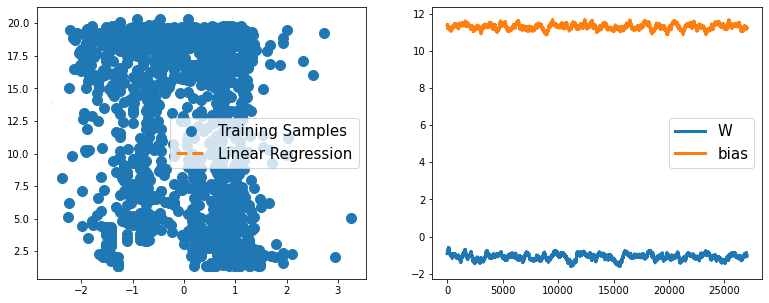

In [25]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()